## Xgboost

In [4]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplolib', 'inline')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn import metrics

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import random

from lime import lime_tabular

from dateutil.parser import parse
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.5f}'.format

In [5]:
data = pd.read_csv(r'Metro_Interstate_Traffic_Volume.csv.gz', compression='gzip')

data['year'] = data['date_time'].apply(lambda x: int(x[:4]))
data['month'] = data['date_time'].apply(lambda x: int(x[5:7]))
data['weekday'] = pd.to_datetime(data['date_time']).apply(lambda x: x.weekday())
data['hour'] = pd.to_datetime(data['date_time']).apply(lambda x: x.hour)
data['isholiday'] = (data['holiday'] == 'None').apply(float)

data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,year,month,weekday,hour,isholiday
0,None,288.28000,0.00000,0.00000,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012,10,1,9,1.00000
1,None,289.36000,0.00000,0.00000,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012,10,1,10,1.00000
2,None,289.58000,0.00000,0.00000,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012,10,1,11,1.00000
3,None,290.13000,0.00000,0.00000,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012,10,1,12,1.00000
4,None,291.14000,0.00000,0.00000,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012,10,1,13,1.00000


In [6]:
#Create objects X and y

X = data[['year','month','weekday','hour','isholiday']]
y = data['traffic_volume']

#Create Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=100, random_state=12345, shuffle=False)

xgb_regr = XGBRegressor()
xgb_regr.fit(X_train,y_train)

xgb_fcst = xgb_regr.predict(X_test)

print(metrics.r2_score(list(y_test),list(xgb_fcst)))

0.9741936211093799


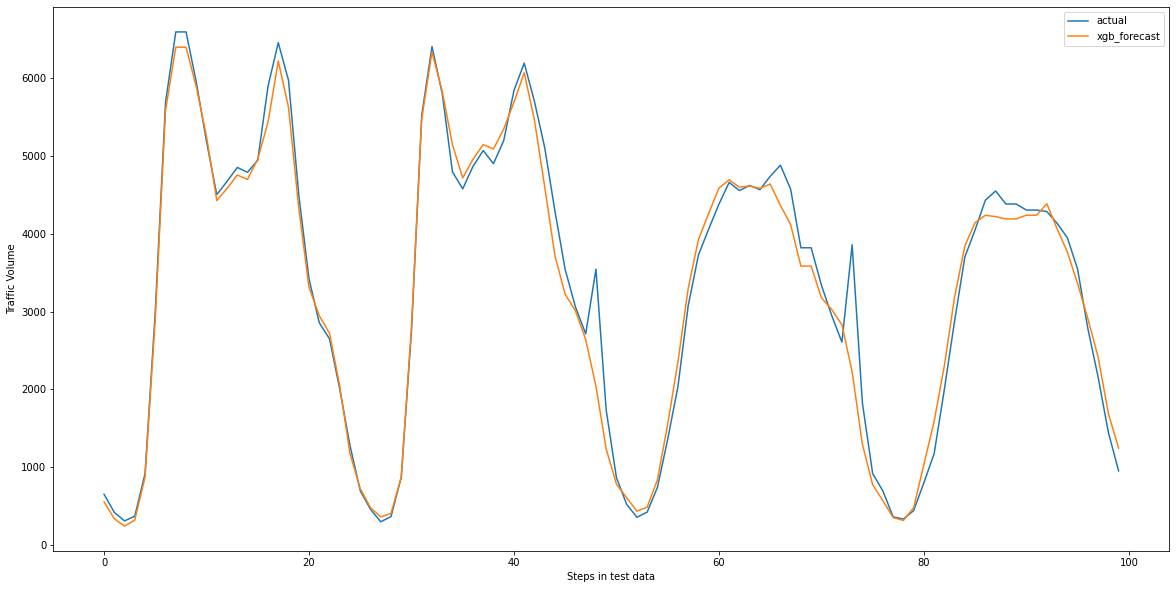

In [7]:
plt.figure(figsize=(20,10))
plt.plot(list(y_test))
plt.plot(list(xgb_fcst))
plt.legend(['actual','xgb_forecast'])
plt.ylabel('Traffic Volume')
plt.xlabel('Steps in test data')
plt.show()

In [8]:
#explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names= X_train.columns.values.tolist(), class_names=['traffic_volume'])
#explainer

In [9]:
#for i in range(len(X_test)):
#    exp = explainer.explain_instance(X_test.values[i], xgb_regr.predict)
#    #exp.show_in_notebook(show_table=True)

In [10]:
lgbm_regr = LGBMRegressor()
lgbm_regr.fit(X_train,y_train)

lgbm_fcst = xgb_regr.predict(X_test)

print(metrics.r2_score(list(y_test),list(lgbm_fcst)))

0.9741936211093799


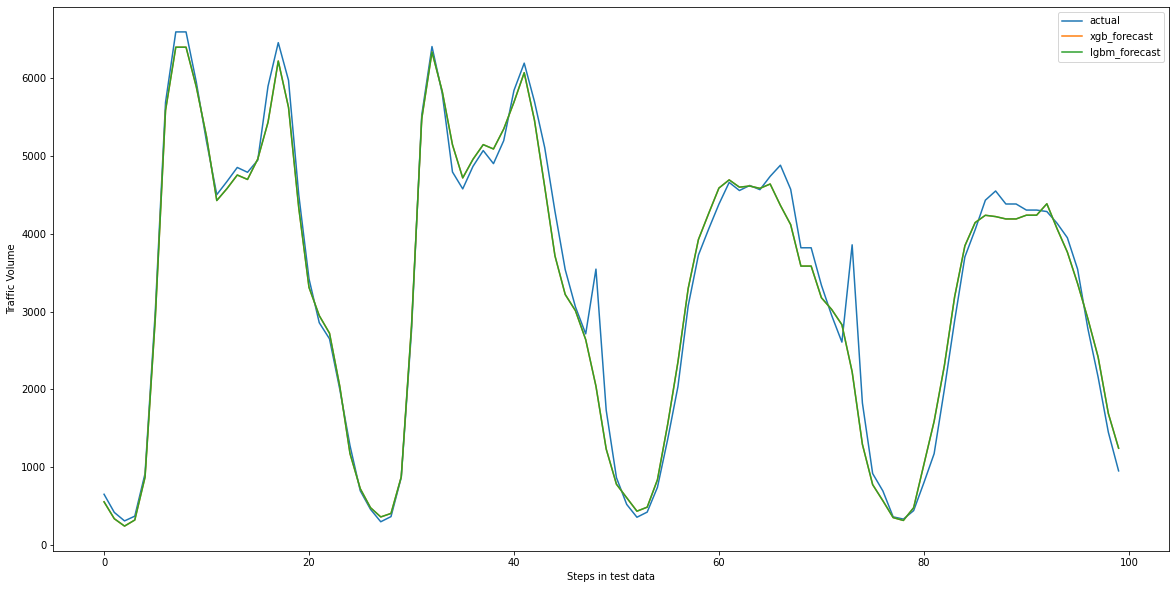

In [11]:
plt.figure(figsize=(20,10))
plt.plot(list(y_test))
plt.plot(list(xgb_fcst))
plt.plot(list(lgbm_fcst))
plt.legend(['actual','xgb_forecast','lgbm_forecast'])
plt.ylabel('Traffic Volume')
plt.xlabel('Steps in test data')
plt.show()

In [12]:
random.seed(0)

xgb_opt_regr = BayesSearchCV(XGBRegressor(),
                             {'learning_rate':(10e-6, 1.0, 'log-uniform'),
                              'max_depth': Integer(0,50,'uniform'),
                              'n_estimators':(10,1000,'log-uniform')},
                              n_iter=10, cv=3)

xgb_opt_regr.fit(X_train,y_train)

xgb_tuned_fcst = xgb_opt_regr.best_estimator_.predict(X_test)

print(metrics.r2_score(list(y_test),list(xgb_tuned_fcst)))

0.9684959611121234


In [13]:
random.seed(0)

lgbm_opt_regr = BayesSearchCV(LGBMRegressor(),
                             {'learning_rate':(10e-6, 1.0, 'log-uniform'),
                              'max_depth': Integer(0,50,'uniform'),
                              'n_estimators':(10,1000,'log-uniform')},
                              n_iter=10, cv=3)

lgbm_opt_regr.fit(X_train,y_train)

lgbm_tuned_fcst = lgbm_opt_regr.best_estimator_.predict(X_test)

print(metrics.r2_score(list(y_test),list(lgbm_tuned_fcst)))

0.9550871024654151


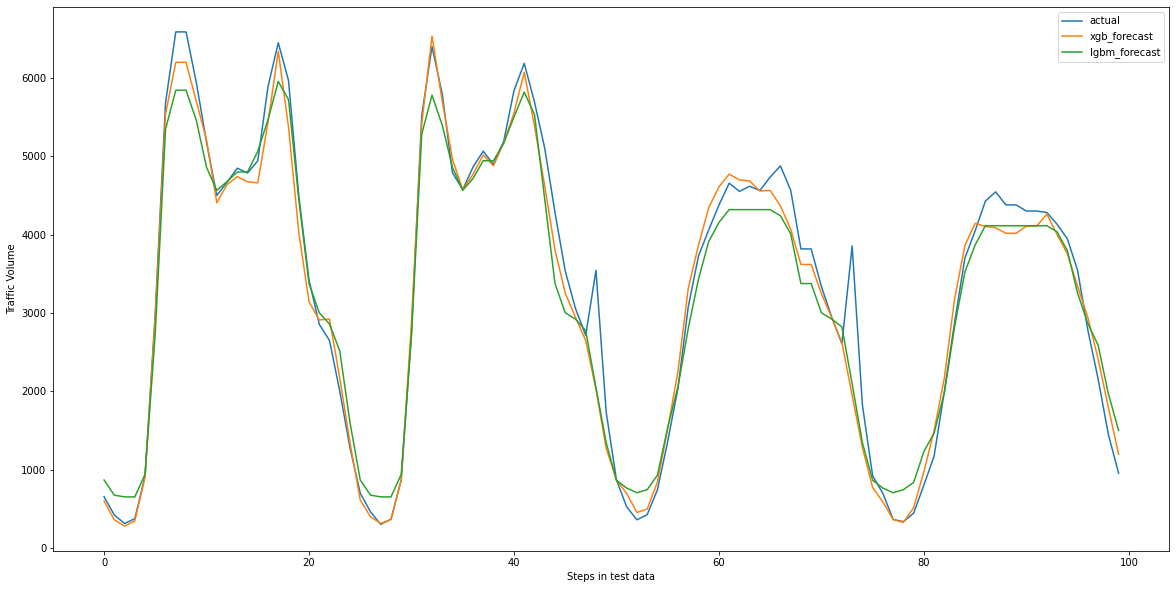

In [14]:
plt.figure(figsize=(20,10))
plt.plot(list(y_test))
plt.plot(list(xgb_tuned_fcst))
plt.plot(list(lgbm_tuned_fcst))
plt.legend(['actual','xgb_forecast','lgbm_forecast'])
plt.ylabel('Traffic Volume')
plt.xlabel('Steps in test data')
plt.show()